### This jupyter notebook runs the result of predicting VIX index value and Trading VXX 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

from data_reader import z_score_inv
from next_batch import LSTM_WINDOW_SIZE, INPUT_SIZE, PREDICTORS
from next_batch import get_trainable_data

from data_reader import read_vxx

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


height has been deprecated.



In [3]:
# random number seed
seed=4

In [4]:
# set DISPLAY=0;
plt.ion()

In [5]:
##'data.npz' saves y variables as value of volatility
##'data_binary.npz' saves y variables as 0(decrease) and 1(increase)
DATA_FILE = 'data.npz'
#DATA_FILE = 'data_binary.npz'
if not os.path.exists(DATA_FILE):
    (x_train, y_train), (x_test, y_test), mean, std = get_trainable_data()
    np.savez_compressed(DATA_FILE, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
                        mean=mean, std=std)
else:
    d = np.load(DATA_FILE)
    x_train = d['x_train']
    y_train = d['y_train']
    x_test = d['x_test']
    y_test = d['y_test']
    mean = d['mean']
    std = d['std']


###################################

x_train = x_train[:,:,[0,1,2]]
x_test = x_test[:,:,[0,1,2]]

###################################

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)

print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

#train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=seed)

##################################

print('x_train.shape =',x_train.shape)
print('x_val.shape =',x_val.shape)


x_train.shape = (2122, 10, 3)
y_train.shape = (2122, 1)
x_test.shape = (616, 10, 3)
y_test.shape = (616, 1)
x_train.shape = (1697, 10, 3)
x_val.shape = (425, 10, 3)


In [6]:
# Define the model function (following TF Estimator Template)
# Here the class remain the same for all the structures
class TFClassifier:
    def __init__(self,
                input_size, 
                window_size,
                logit_function,
                max_iter=600,
                learning_rate=0.0001,
                batch_size=32,
                model_dir="./tfclassifier",
                load_from_disk=False,
                summary_steps=None,
                dtype=tf.float32,
                use_adam_optimizer=False,
                X_val=None,
                Y_val=None):

        
        self.learning_rate=learning_rate
        self.max_iter=max_iter
        self.batch_size=batch_size
        self.dtype=dtype
        self.use_adam_optimizer=use_adam_optimizer
        self.g=tf.Graph()
        
        with self.g.as_default():           
            self.build_model(input_size,window_size,logit_function)
        
        self.load_from_disk=load_from_disk
        if not self.load_from_disk:
            shutil.rmtree(model_dir,ignore_errors=True)
        self.dir=model_dir

        if summary_steps is None:
            self.summary_steps=max_iter//20
        else:
            self.summary_steps=summary_steps
   
        self.X_val=X_val
        self.Y_val=Y_val
        
        self.perms=[]
        
    #Define loss function and optimizer          
    def build_model(self,input_size,window_size,logit_function):
    
        self.global_step = tf.Variable(0,name='global_step')
        self.in_training=tf.placeholder_with_default(0.0,shape=(None),name="in_training")
        
        self.X=tf.placeholder(self.dtype,[None,window_size,input_size],name="X")
        self.Y=tf.placeholder(self.dtype,[None,1],name="Y")
   
        # Predictions
        self.pred=logit_function(self.X,self.in_training)
        
        # Define loss and optimizer
        # If we want to predict value, use MAPE;
        # If we want to predict direction, use cross entropy.
        self.loss = tf.reduce_mean(tf.abs(tf.divide(tf.subtract(self.pred,self.Y),self.Y)))
    
        if self.use_adam_optimizer:
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        else:
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        self.training_op = optimizer.minimize(self.loss, global_step=self.global_step)
    
        tf.summary.scalar("loss",self.loss)
        self.summary=tf.summary.merge_all()
        
        self.init = tf.global_variables_initializer()
        
        return 

    #Report value of loss function over a series of epochs
    def report_summary(self,X,Y,sess,epoch,saver,train_summary_writer,val_summary_writer):
        # we only want to report on a small say 1000, subset or train and valdiation
        # sets, if not , reporting will be more expensive than training
        N=min(1000,X.shape[0])
        perm=np.random.choice(X.shape[0],N)
        self.last_checkpoint=saver.save(sess,self.dir+"/optimization.ckpt",global_step=epoch)
        xu=X[perm]
        yu=Y[perm]
        train_loss,train_summary=sess.run(fetches=[self.loss,self.summary],
            feed_dict={self.X:xu,
                       self.Y:yu})  
        train_summary_writer.add_summary(train_summary,epoch)
        
        N=min(1000,self.X_val.shape[0])
        perm=np.random.choice(self.X_val.shape[0],N)
        val_loss,val_summary=sess.run(fetches=[self.loss,self.summary],
            feed_dict={self.X:self.X_val[perm],
                       self.Y:self.Y_val[perm]}
                       )  
        val_summary_writer.add_summary(val_summary,epoch)
        print("Epoch", epoch, "Loss =",train_loss,"Evaluation Loss =",val_loss)
    
    #Train Neural Network
    def fit(self,X,Y):
        N=len(X)
        
        with tf.Session(graph=self.g) as sess:
            #tf.set_random_seed(3)
            
            saver = tf.train.Saver()
            if self.load_from_disk:
                saver.restore(sess,tf.train.latest_checkpoint(self.dir))
            else:
                if not os.path.exists(self.dir):
                    os.mkdir(self.dir)
                sess.run(self.init)
            
            step0=tf.train.global_step(sess,self.global_step)
            train_summary_writer = tf.summary.FileWriter(self.dir+"/train", self.g)
            val_summary_writer = tf.summary.FileWriter(self.dir+"/validation", self.g)
            step=step0
            step_last=step
            
            #set random seed
            np.random.seed(seed)
            while step<step0+self.max_iter:  
                if  (step% self.summary_steps)<=(step_last % self.summary_steps): # we have grapped around
                   self.report_summary(X,Y,sess,step,saver,train_summary_writer,val_summary_writer)
                step_last=step
                
                ##################################
                #need to set seed to make the result reproducible
                perm=np.random.permutation(N)
                
                self.perms.append(perm)
                
                ##################################
                for i in range(0,N,self.batch_size):
                    Xb=X[perm[i:i+self.batch_size]]
                    Yb=Y[perm[i:i+self.batch_size]]
                    sess.run([self.training_op],feed_dict={self.X:Xb,
                                                           self.Y:Yb,
                                                           self.in_training:1.0
                                                           }) 
                    
                    step+=1
            self.report_summary(X,Y,sess,step0+self.max_iter,saver,train_summary_writer,val_summary_writer)
            self.load_from_disk=True # make sure we restart next fit from previous level so that we can call fit multiple times

    #Predict y variables
    def predict(self,X,batch_size=1000):
        
        with tf.Session(graph=self.g) as sess:
            saver = tf.train.Saver()
            saver.restore(sess,tf.train.latest_checkpoint(self.dir))
            ys=[]
            for start in range(0,X.shape[0],batch_size):
                
                yb=sess.run([self.pred],feed_dict={self.X:X[slice(start,start+batch_size)]})
                ys.append(yb)
        y=np.concatenate(ys,axis=1).ravel()
        return y

In [7]:
#Definition of RNN structure
#We modify architecture to reduce parameters and improve robustness in this class
class LSTM_Model:
    def __init__(self,input_size = INPUT_SIZE,window_size = LSTM_WINDOW_SIZE,hidden1 = 32,hidden2 = 16):
        self.input_size=input_size
        self.window_size=window_size
        self.hidden1=hidden1
        self.hidden2=hidden2
        
    def __call__(self,x,in_training):
        #GRU cell
        cell1 =tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.GRUCell(self.hidden1,
                                                                    activation=tf.nn.tanh,
                                                                    kernel_initializer=tf.glorot_uniform_initializer(seed=seed)
                                                                    ),
                                                                    input_keep_prob=1.0-0.0*in_training # no dropout for first layer
                                                                    )
        #LSTM cell
        '''
        cell1 =tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(self.hidden1,state_is_tuple = True,
                                                                     initializer=tf.glorot_uniform_initializer(seed=seed)),
                                                                     input_keep_prob=1.0-0.0*in_training # no dropout for first layer
                                                                     )
        '''
        
        output, state = tf.nn.dynamic_rnn(cell1, 
                                      x,
                                      #initial_state=initial_state, 
                                      dtype = tf.float32)
        
        #This output1 below designs for GRU layer
        output1=tf.layers.dense(inputs=state, units=self.hidden2,activation='sigmoid',
                                kernel_initializer=tf.glorot_uniform_initializer(seed=seed)
                                )
        
        #This output1 below designs for LSTM layer
        '''
        output1=tf.layers.dense(inputs=state.h, units=self.hidden2,activation='sigmoid',kernel_initializer=tf.glorot_uniform_initializer(seed=seed))
        '''
        output2=tf.layers.dense(inputs=output1, units=1,kernel_initializer=tf.glorot_uniform_initializer(seed=seed))
       

        print(x.shape)
        #print(state.h.shape)
        print(output1.shape)
        print(output2.shape)
        return output2

In [8]:
# specify the nodes in each layer, number of features and rolling window size 
INPUT_SIZE = x_train.shape[2]
lstm_model=LSTM_Model(INPUT_SIZE,LSTM_WINDOW_SIZE,32,16)

In [9]:
# Build the Estimator
model = TFClassifier(INPUT_SIZE,
                     LSTM_WINDOW_SIZE,
                     lstm_model,
                     max_iter=20000,
                     #max_iter=30000,
                     learning_rate=0.001,
                     batch_size=32,
                     model_dir="./tfclassifier",
                     load_from_disk=False,
                     summary_steps=None,
                     dtype=tf.float32,
                     use_adam_optimizer=True,
                     X_val=x_val,
                     Y_val=y_val
                    )

(?, 10, 3)
(?, 16)
(?, 1)


In [10]:
model.fit(x_train,y_train)

Epoch 0 Loss = 3.6196485 Evaluation Loss = 1.2809324
Epoch 1026 Loss = 1.4056376 Evaluation Loss = 1.0527811
Epoch 2052 Loss = 2.4513278 Evaluation Loss = 0.9375877
Epoch 3024 Loss = 1.0992076 Evaluation Loss = 0.9977112
Epoch 4050 Loss = 0.94043404 Evaluation Loss = 0.81442267
Epoch 5022 Loss = 1.1513605 Evaluation Loss = 0.7775317
Epoch 6048 Loss = 2.106229 Evaluation Loss = 0.7892916
Epoch 7020 Loss = 1.0438821 Evaluation Loss = 0.8284604
Epoch 8046 Loss = 4.0037775 Evaluation Loss = 0.81953937
Epoch 9018 Loss = 1.3120128 Evaluation Loss = 0.5428134
Epoch 10044 Loss = 0.7620483 Evaluation Loss = 0.6969057
Epoch 11016 Loss = 1.1939605 Evaluation Loss = 0.5229518
Epoch 12042 Loss = 0.6218532 Evaluation Loss = 0.50585705
Epoch 13014 Loss = 1.0527558 Evaluation Loss = 0.79090464
Epoch 14040 Loss = 0.69797754 Evaluation Loss = 0.60521406
Epoch 15012 Loss = 1.4884526 Evaluation Loss = 0.67144924
Epoch 16038 Loss = 2.579727 Evaluation Loss = 0.5449275
Epoch 17010 Loss = 0.4718442 Evaluatio

In [11]:
y_pred=model.predict(x_test)

train_pred = model.predict(x_train)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pred_sigmas = [z_score_inv(pred, mean, std) for pred in y_pred.flatten()]
true_sigmas = [z_score_inv(true, mean, std) for true in y_test.flatten()]
dummy_sigmas = [z_score_inv(dummy, mean, std) for dummy in np.roll(y_test.flatten(), shift=1)]

train_sigmas = [z_score_inv(pred, mean, std) for pred in train_pred.flatten()]
train_true_sigmas = [z_score_inv(true, mean, std) for true in y_train.flatten()]

train_mape = mean_absolute_percentage_error(np.array(train_true_sigmas), np.array(train_sigmas))
test_mape = mean_absolute_percentage_error(np.array(true_sigmas), np.array(pred_sigmas))
dummy_mape = mean_absolute_percentage_error(np.array(true_sigmas), np.array(dummy_sigmas))

print('train_mape: '+'{:.2%}'.format(train_mape/100))
print('test_mape: '+'{:.2%}'.format(test_mape/100))
print('dummy_mape: '+'{:.2%}'.format(dummy_mape/100))

INFO:tensorflow:Restoring parameters from ./tfclassifier/optimization.ckpt-20000
INFO:tensorflow:Restoring parameters from ./tfclassifier/optimization.ckpt-20000
train_mape: 6.02%
test_mape: 6.62%
dummy_mape: 3.22%


In [12]:
#trade vxx
#Train Period: 04/12/2015-04/27/2015
#Trade Period: 04/24/2015-10/03/2017 predict value starts from 04/27/2015

vxx = read_vxx()
vxx = vxx.loc[vxx.index <= '2017-10-03 00:00:00']
vxx = vxx.loc[vxx.index >= '2015-04-24 00:00:00']

date_idx = vxx.index[1:]

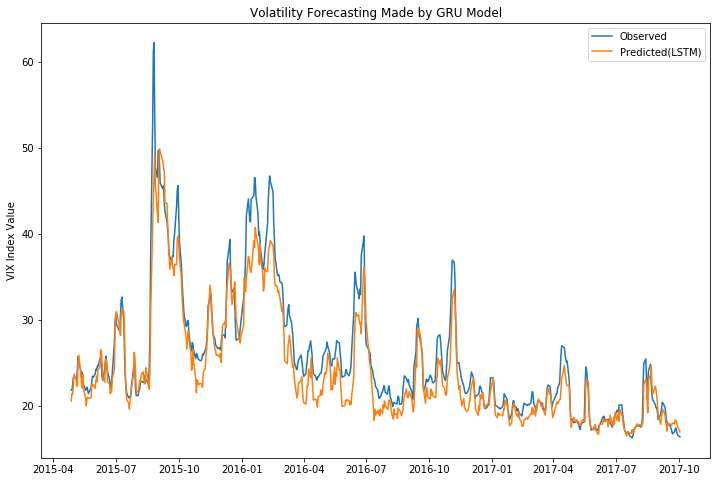

In [13]:
#Plot Pictures
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)
ax.plot(date_idx,true_sigmas,label='Observed')
ax.plot(date_idx,pred_sigmas,label='Predicted(LSTM)')
ax.legend(loc='upper right')
ax.set_ylabel('VIX Index Value')
ax.set_title("Volatility Forecasting Made by GRU Model")
f.savefig('GRU.png')

In [14]:
#Prepare trade data
prev_sigmas = [ z_score_inv(x_test[i][-1][0], mean, std) for i in range(len(x_test)) ]
vxx_df = pd.DataFrame(data = {'sigma': vxx})
#vxx_df = apply_delta_t_to_data_frame(vxx_df)
vxx_df = vxx_df.rename(index=str, columns={"sigma": "vxx"})
vxx_ret = pd.DataFrame(data = {"vxx_ret": np.log(vxx_df['vxx'].shift(-1)/vxx_df['vxx'])[1:]})

vxx_ret['vix'] = prev_sigmas
vxx_ret['pred_vix'] = pred_sigmas
vxx_ret['pred_ret'] = [ 1 if pred_sigmas[i] > prev_sigmas[i] else -1 for i in range(len(pred_sigmas))]

#dummy strategy
#vxx_ret['pred_ret'] = [ 1 if np.random.uniform(0,1) > 0.5 else -1 for i in range(len(pred_sigmas))]


vxx_ret['strategy_ret'] = vxx_ret['pred_ret']*vxx_ret['vxx_ret']
strategy_ret = vxx_ret['strategy_ret'].sum()


win_prob = vxx_ret[vxx_ret['strategy_ret']>0].shape[0]/vxx_ret.shape[0]

vxx_ret['true_vix'] = true_sigmas
vxx_ret['vix_ret'] = np.log(vxx_ret['true_vix']/vxx_ret['vix'])*vxx_ret['pred_ret']
cor_prob = vxx_ret[vxx_ret['vix_ret']>0].shape[0]/vxx_ret.shape[0]

pnl=vxx_ret['strategy_ret'].cumsum()

In [15]:
print('Correct Probability of predicting VIX index: '+'{:.2%}'.format(cor_prob))
print('Winning Probability of trading strategy: '+'{:.2%}'.format(win_prob))

Correct Probability of predicting VIX index: 57.63%
Winning Probability of trading strategy: 58.28%


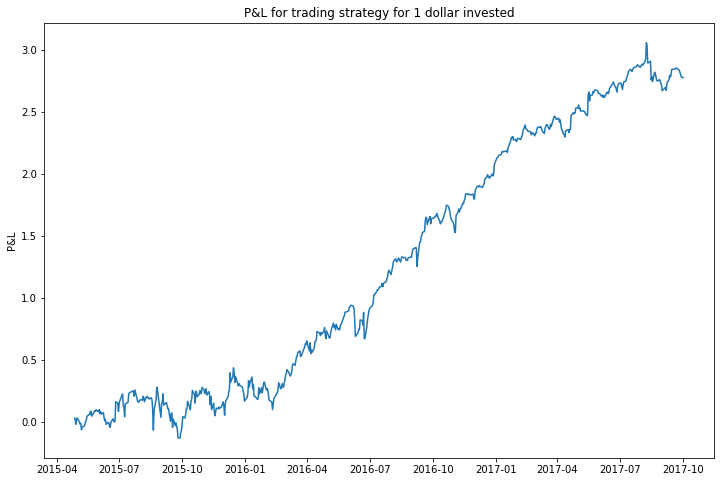

In [16]:
f = plt.figure(figsize=[12,8])
ax = f.add_subplot(111)
ax.plot(date_idx,pnl)
ax.set_ylabel('P&L')
ax.set_title('P&L for trading strategy for 1 dollar invested')
f.savefig('Pnl_naive.png')